In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import sys
import circuitmap as cm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import time

import glob

# hack for now
import sys
sys.path.append('../')
import grid_utils
import subtract_utils


from mpl_toolkits.axes_grid1 import ImageGrid

2022-07-29 11:49:13.403219: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ba2617/code-server-3.12.0-linux-amd64/:
2022-07-29 11:49:13.590309: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ba2617/code-server-3.12.0-linux-amd64/:
2022-07-29 11:49:13.604926: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ba2617/code-server-3.12.0-linux-amd64/:


# Load fitted model

We'll assume that we've already fit mbcs models to each plane in a batch job. These models are saved in a pickle file which contains a list -- one model for each plane of the data.

In [17]:
multispot_results_path = '../scripts/220319_cell1_pv_multigrid_A_grid_cmReformat_subtractr_caviar_results.npz'
ms_results = np.load(multispot_results_path, allow_pickle=True)

In [18]:
singlespot_results_path = '../scripts/220319_cell1_pv_multigrid_A_planes_cmReformat_subtractr_caviar_results.npz'
ss_results = np.load(singlespot_results_path, allow_pickle=True)

In [19]:
def sort_results(results):
    results = dict(results)
    model_state = results['model_state'].item()
    targets = results['targets']
    N = targets.shape[0]

    # ensure that targets are in the right order so that things work when reshaped
    idxs = np.lexsort((targets[:,-1], targets[:,-2], targets[:,-3]))
    
    # reorder everything in results
    for (key, value) in model_state.items():
        if value.shape and value.shape[0] == N: # first condition ensures we don't index into zero-length tuple
            model_state[key] = value[idxs]
    results['model_state'] = model_state
    results['targets'] = targets[idxs]

    return results

def circuitmap_lasso_cv(stim_mat, pscs, K=5):
    """
    For each power, return a list of inferred weights via L1 regularized regression.
    The L1 penalty is determined by K-fold cross validation.
    
    returns:
        responses: (num_powers x num_cells) inferred weight at each power
    """
    powers = np.unique(stim_mat.ravel())[1:] # exclude zero
    num_powers = len(powers)
    N = stim_mat.shape[0]
    responses = np.zeros((num_powers, N))
    models = []
    for pidx, power in enumerate(powers):
        
        curr_trials = np.max(stim_mat, axis=0) == power
        curr_stim = stim_mat[:,curr_trials]
        curr_pscs = pscs[curr_trials,:]
        stim_binarized = curr_stim > 0 
        
        # fit lasso with cross val
        print('Starting lasso CV')
        start_time = time.time()
        y = np.trapz(curr_pscs, axis=-1)
        model = LassoCV(cv=K, n_jobs=-1, positive=True, n_alphas=10).fit(stim_binarized.T, y)
        end_time = time.time() - start_time
        print('CV at single power took %f secs' % end_time)
        responses[pidx] = model.coef_
        models.append(model)
        
    return responses, models


ss_results = sort_results(ss_results)
ms_results = sort_results(ms_results)

In [5]:
resp_demixed, _ = circuitmap_lasso_cv(ms_results['stim_mat'], ms_results['demixed_matrix'])
resp_raw, _ = circuitmap_lasso_cv(ms_results['stim_mat'], ms_results['raw_matrix'])

Starting lasso CV
CV at single power took 44.744920 secs
Starting lasso CV
CV at single power took 39.277149 secs
Starting lasso CV
CV at single power took 21.938979 secs
Starting lasso CV
CV at single power took 71.723264 secs
Starting lasso CV
CV at single power took 52.225147 secs
Starting lasso CV
CV at single power took 29.472857 secs


In [20]:

ss_plane = 50
plane_idxs = ms_results['targets'][:,-1] == ss_plane
ms_weights = ms_results['model_state']['mu']
ms_weights_this_plane = ms_weights[plane_idxs]

ss_map_raw = ss_results['raw_map']
ss_map_demixed = ss_results['demixed_map']
ms_map_demixed = ms_results['demixed_map']
ss_weights = ss_results['model_state']['mu'].reshape(1, *ss_map_demixed.shape[1:])
ms_weights_plot = ms_weights_this_plane.reshape(1, *ss_map_demixed.shape[1:])

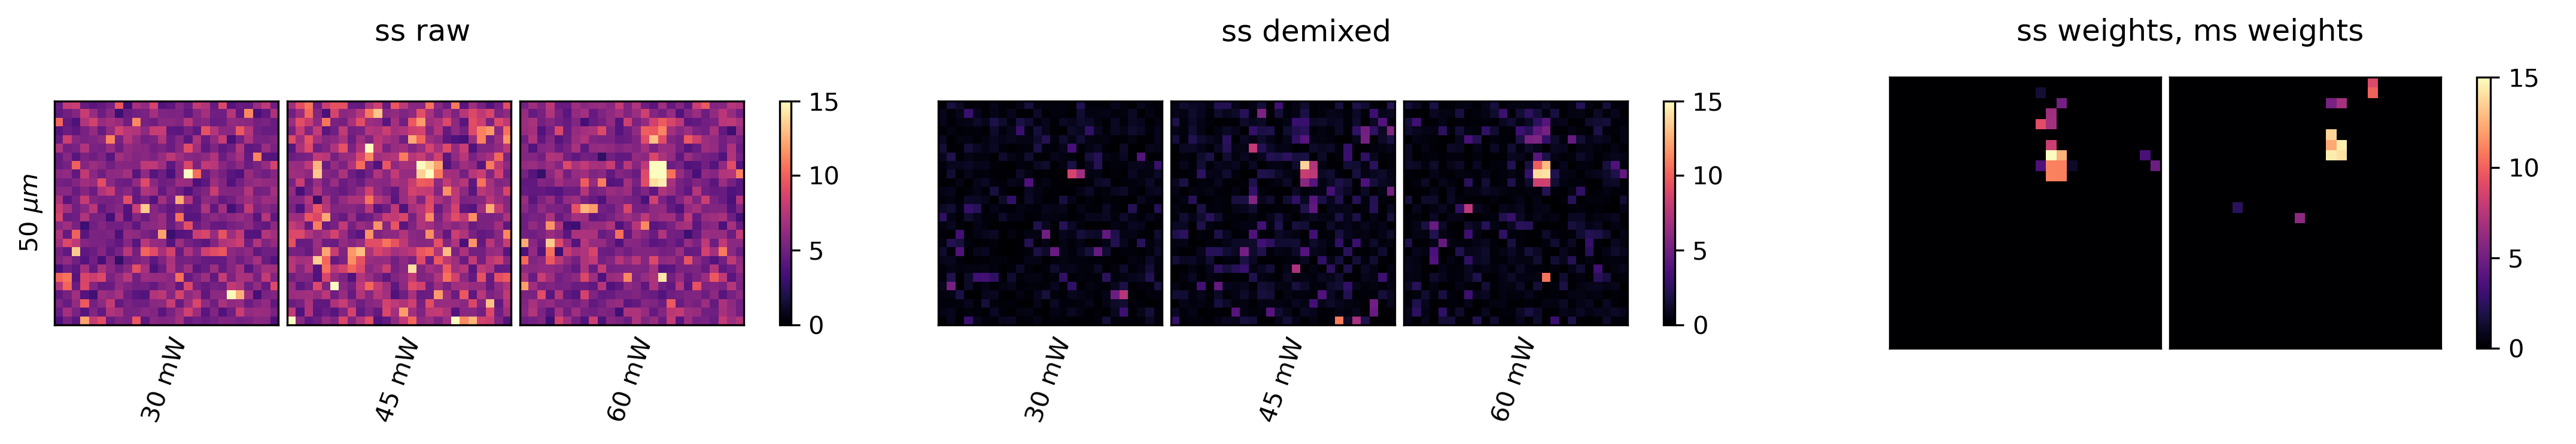

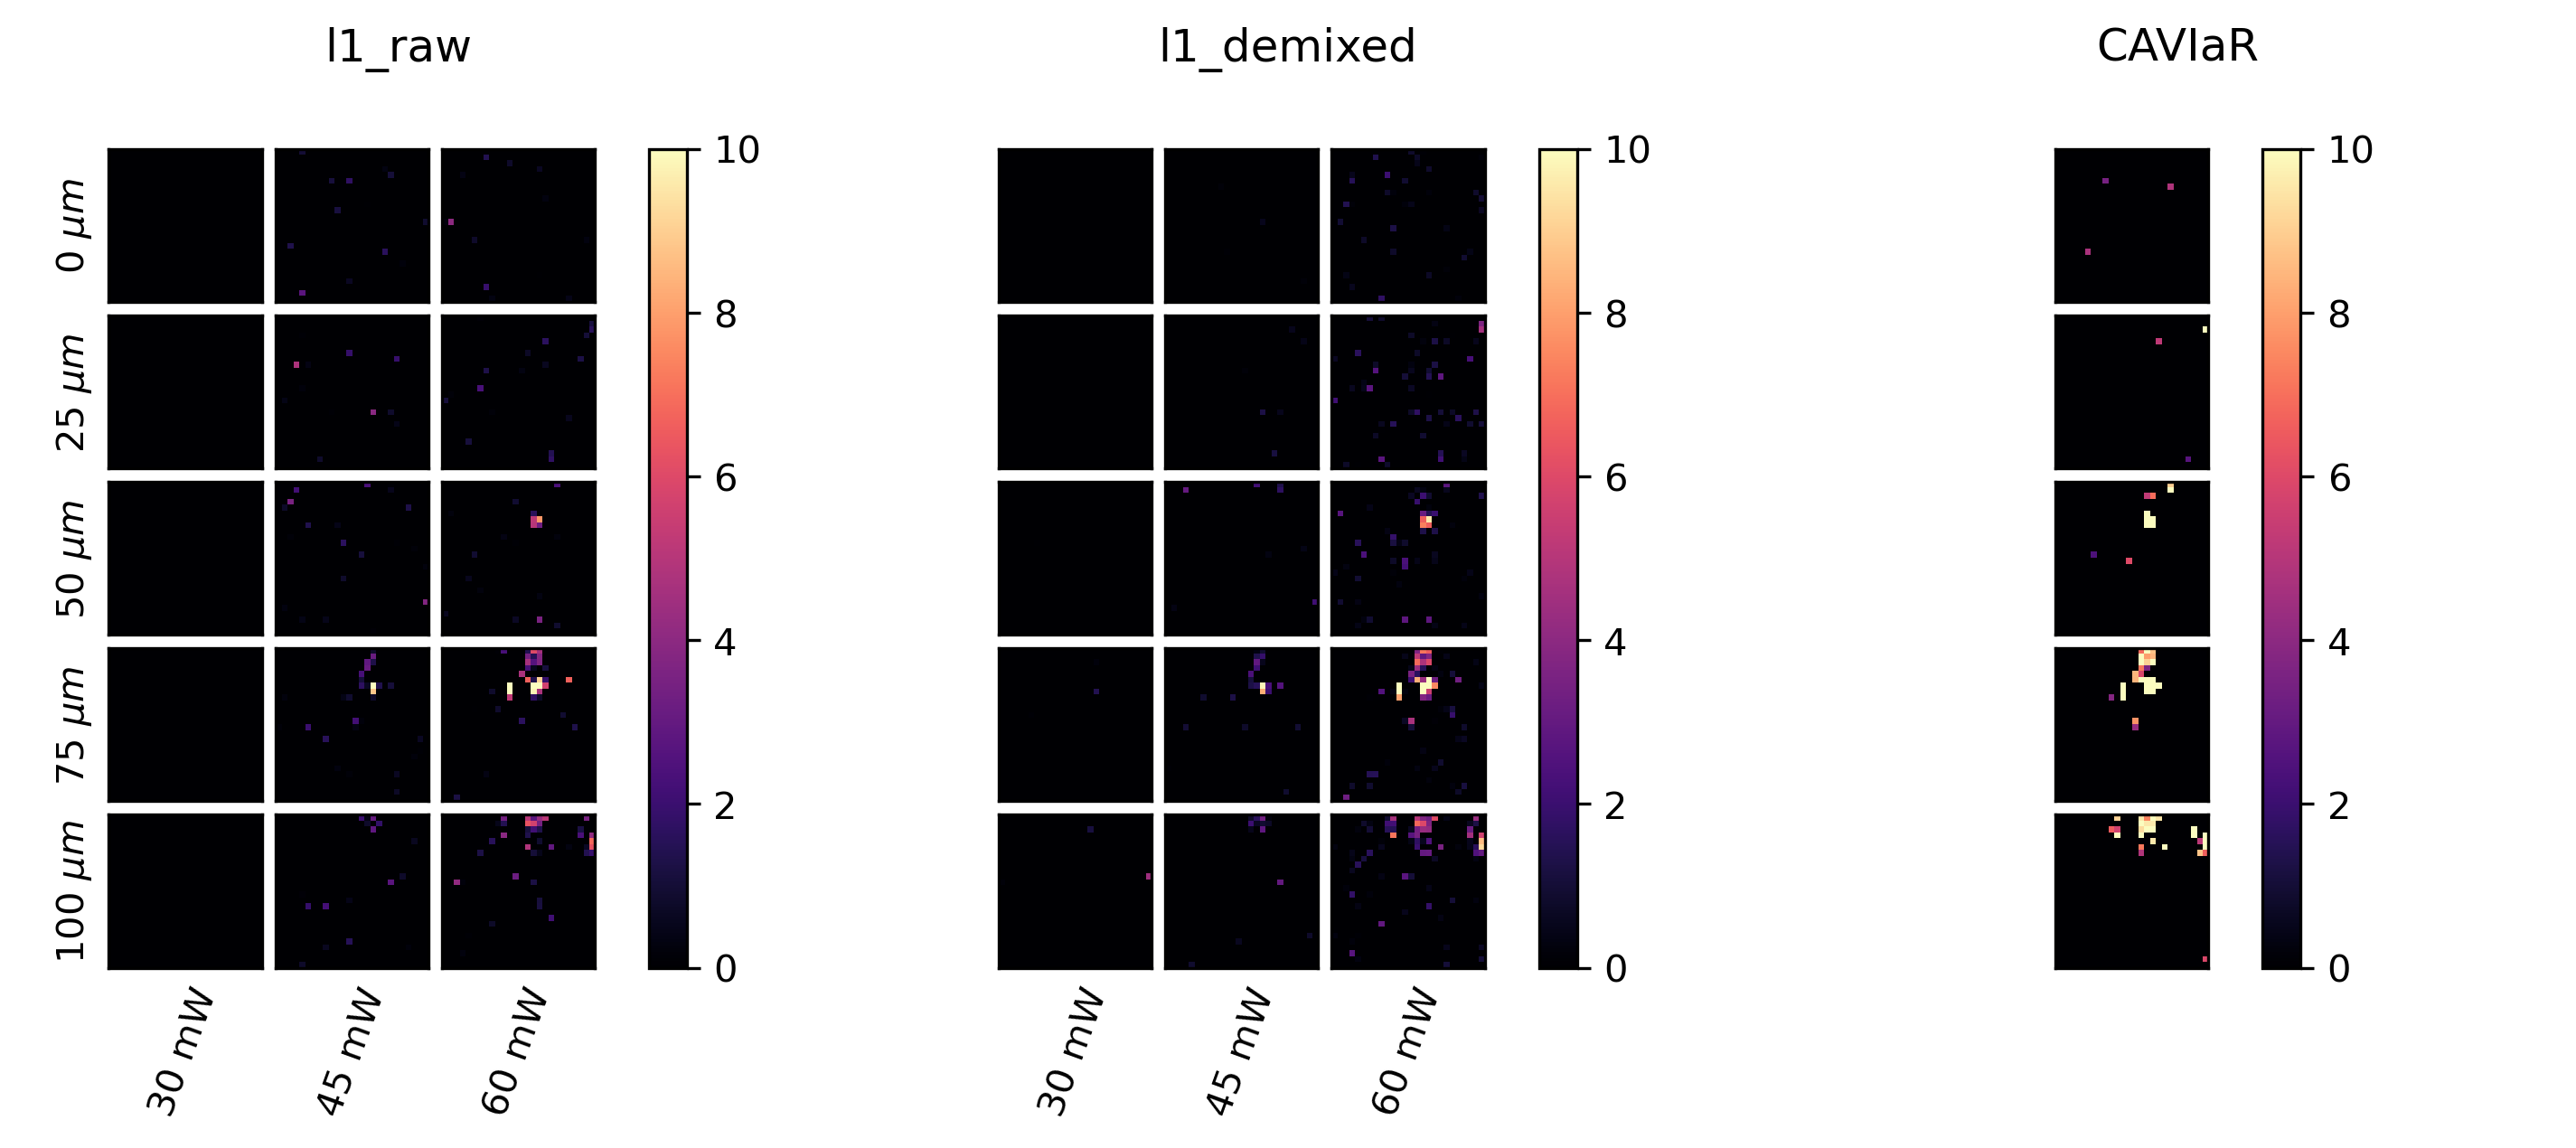

<Figure size 432x288 with 0 Axes>

In [6]:
num_planes = ss_map_raw.shape[-1]
num_powers = ss_map_raw.shape[0]
fig1 = plt.figure(figsize=(6 * num_powers, 2), dpi=300, facecolor='white')

# plot single-vs-multi comparison for one plane
grid_utils.plot_multi_means(fig1,
    [ss_map_raw, ss_map_demixed, np.concatenate((ss_weights, ms_weights_plot,), axis=0)],
    np.arange(num_planes),
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['ss raw', 'ss demixed', 'ss weights, ms weights'],
    vranges=[(0,15), (0,15), (0,15), (0,15)],
    powers=np.unique(ss_results['powers']),
    show_powers=(True, True, False),
    zs=[ss_plane],
    )

fig2 = plt.figure(figsize=(4 * num_powers, 4), dpi=300, facecolor='white')
# # # plot multispot with lasso comparison
grid_utils.plot_multi_means(fig2,
    [resp_raw.reshape(-1, 26, 26, 5), resp_demixed.reshape(-1, 26, 26, 5),
         ms_weights.reshape(1, 26, 26, 5),],
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['l1_raw', 'l1_demixed', 'CAVIaR',],
    vranges=[(0,10), (0,10), (0,10), (0,10)],
    powers=np.unique(ss_results['powers']),
    show_powers = [True, True, False],
    zs=np.unique(ms_results['targets'][:,-1]),
    )

plt.show()
plt.tight_layout()

# Image stacks

In [21]:
def draw_sizebar(ax, pixel_size=1.3, sizebar_length=20, color='white', loc='lower left'):
    """
    Draw a horizontal bar with length of 0.1 in data coordinates,
    with a fixed label underneath.
    """
    num_pixels = sizebar_length / pixel_size
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    asb = AnchoredSizeBar(ax.transData,
                          num_pixels,
                          r"%d ${\mu m}$" % sizebar_length,
                          pad=0.1, borderpad=0.5, sep=5,
                          loc=loc,
                          frameon=False,
                          color=color)
    ax.add_artist(asb)

In [23]:
import imageio as io

stack = io.volread('../data/marta/pv_cre_to_E/stacks/03192022/cell1_pv_multigrid25_00001.tif')
spacing = 25
num_planes = 100 // spacing + 1
stack_grn, stack_red = [stack[i::2] for i in range(2)]
im_grn = np.array([np.mean(stack_grn[i::num_planes], axis=0) for i in range(num_planes)]).astype(int)
im_red = np.array([np.mean(stack_red[i::num_planes], axis=0) for i in range(num_planes)]).astype(int)

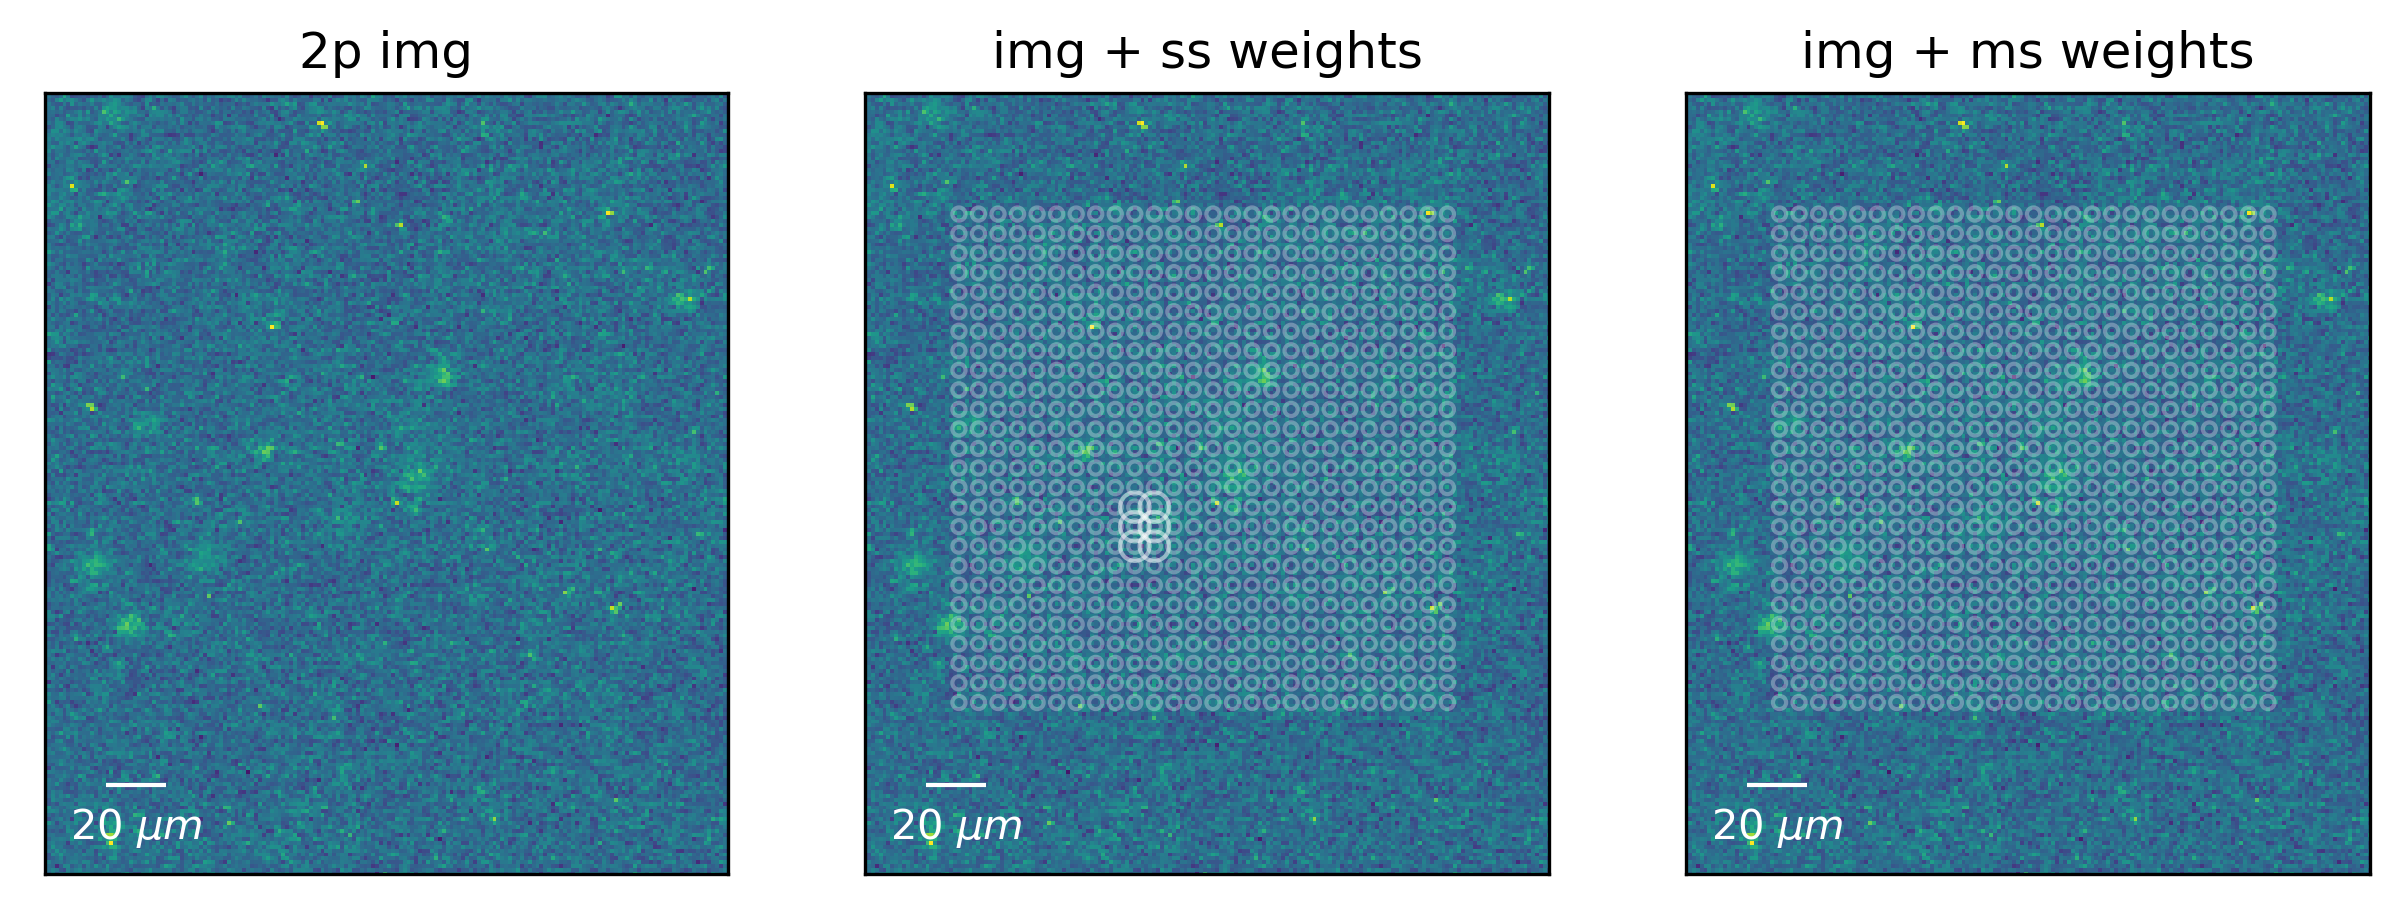

In [29]:
targets_this_plane = ss_results['targets']
min_x, max_x = int(np.min(targets_this_plane[:,0])), int(np.max(targets_this_plane[:,0]))
min_y, max_y = int(np.min(targets_this_plane[:,1])), int(np.max(targets_this_plane[:,1]))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,20), dpi=300)

# display crop of image around stimulus grid
ms_connected_idxs = ms_weights_this_plane > 0
ss_connected_idxs = ss_weights.ravel() > 0

# plot image without targets
plane_idx = 2
vmax=1500
im1 = axs[0].imshow(im_red[plane_idx], origin='lower', vmax=vmax)
axs[0].set_ylim(150, 350)
axs[0].set_xlim(75, 250)
axs[0].set_xticks([])
axs[0].set_yticks([])
draw_sizebar(axs[0])
axs[0].set_title('2p img')

# plot image with targets and multispot connections
im2 = axs[1].imshow(im_red[plane_idx], origin='lower', vmax=vmax)
axs[1].set_ylim(150, 350)
axs[1].set_xlim(75, 250)
axs[1].set_xticks([])
axs[1].set_yticks([])
draw_sizebar(axs[1])
axs[1].set_title('img + ss weights')
axs[1].scatter(targets_this_plane[ss_connected_idxs,1] ,
            targets_this_plane[ss_connected_idxs,0],
            edgecolor='white',
            facecolor='None',
            s=50,
            alpha=0.5)

axs[1].scatter(targets_this_plane[:,1] ,
            targets_this_plane[:,0],
            edgecolor='white',
            facecolor='None',
            s=10,
            alpha = 0.3
            )

# repeat for multispot connections
im2 = axs[2].imshow(im_red[plane_idx], origin='lower', vmax=vmax)
axs[2].set_ylim(150, 350)
axs[2].set_xlim(75, 250)
axs[2].set_xticks([])
axs[2].set_yticks([])
draw_sizebar(axs[2])
axs[2].set_title('img + ms weights')

axs[2].scatter(targets_this_plane[ms_connected_idxs,1] ,
            targets_this_plane[ms_connected_idxs,0],
            edgecolor='white',
            facecolor='None',
            s=50,
            alpha=0.5)

axs[2].scatter(targets_this_plane[:,1] ,
            targets_this_plane[:,0],
            edgecolor='white',
            facecolor='None',
            s=10,
            alpha = 0.3
            )